In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [2]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [4]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [5]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [6]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [7]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 2

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')

EPOCHS = 100

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2 * (data.읍면동.nunique()), 62 * (data.읍면동.nunique()) #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 64
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

data = data.sort_values(by = ['일자','읍면동'])
data['일자'] = pd.to_datetime(data['일자'])
data = data.set_index(keys = '일자')
#data = data.loc["2019-11-07":, : ]

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

In [8]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [9]:
data.drop(['읍면동'], axis=1, inplace=True)

In [10]:
train.drop(['읍면동'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
train_data = train[:int(0.80 * (len(train) - (look_back_window + forecast_horizon)))]   #train_data = train[:int(0.6 * len(data))]
val_data = train[int(0.80 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [12]:
train_data.shape, val_data.shape, test_data.shape

((8580, 36), (3509, 36), (2002, 36))

In [13]:
look_back_window + forecast_horizon

2002

In [14]:
# Load and preprocess data
#data = data.set_index(keys = 'base_date')
#data = data.query('emd_nm == 24')

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(6579, 1320, 36), y(6579, 682)


In [15]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1320, 36)]        0         
_________________________________________________________________
sci_net (SciNet)             ((None, 682), (None, 36)) 1506794   
Total params: 1,506,794
Trainable params: 1,506,794
Non-trainable params: 0
_________________________________________________________________


In [16]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae


In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

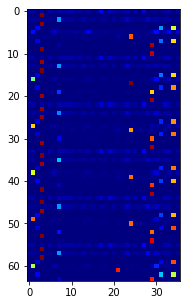

epochs: 1/100, train loss : 0.99243 train mse: 0.99243 train mae: 0.79957  validation loss: 0.72687 validation mse : 0.72687 validation mae: 0.69315
epochs: 2/100, train loss : 0.85660 train mse: 0.72077 train mae: 0.67623  validation loss: 0.62673 validation mse : 0.52659 validation mae: 0.58265
epochs: 3/100, train loss : 0.74542 train mse: 0.52305 train mae: 0.56714  validation loss: 0.55076 validation mse : 0.39882 validation mae: 0.49679
epochs: 4/100, train loss : 0.65619 train mse: 0.38850 train mae: 0.47931  validation loss: 0.49380 validation mse : 0.32291 validation mae: 0.43557
epochs: 5/100, train loss : 0.58415 train mse: 0.29599 train mae: 0.41075  validation loss: 0.44509 validation mse : 0.25027 validation mae: 0.37425
epochs: 6/100, train loss : 0.52607 train mse: 0.23570 train mae: 0.36119  validation loss: 0.40636 validation mse : 0.21270 validation mae: 0.33960
epochs: 7/100, train loss : 0.47841 train mse: 0.19245 train mae: 0.32184  validation loss: 0.37248 valida

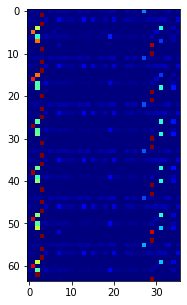

epochs: 11/100, train loss : 0.35267 train mse: 0.10772 train mae: 0.23220  validation loss: 0.29122 validation mse : 0.12248 validation mae: 0.24130
epochs: 12/100, train loss : 0.33146 train mse: 0.09814 train mae: 0.21923  validation loss: 0.27692 validation mse : 0.11960 validation mae: 0.23649
epochs: 13/100, train loss : 0.31302 train mse: 0.09173 train mae: 0.20992  validation loss: 0.26464 validation mse : 0.11735 validation mae: 0.23289
epochs: 14/100, train loss : 0.29688 train mse: 0.08710 train mae: 0.20282  validation loss: 0.25398 validation mse : 0.11529 validation mae: 0.23027
epochs: 15/100, train loss : 0.28267 train mse: 0.08371 train mae: 0.19741  validation loss: 0.24460 validation mse : 0.11333 validation mae: 0.22763
epochs: 16/100, train loss : 0.27008 train mse: 0.08122 train mae: 0.19320  validation loss: 0.23626 validation mse : 0.11119 validation mae: 0.22524
epochs: 17/100, train loss : 0.25886 train mse: 0.07936 train mae: 0.18997  validation loss: 0.22884

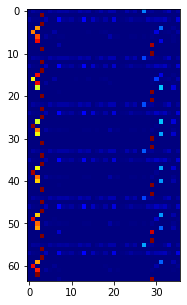

epochs: 21/100, train loss : 0.22416 train mse: 0.07548 train mae: 0.18273  validation loss: 0.20856 validation mse : 0.11940 validation mae: 0.22755
epochs: 22/100, train loss : 0.21738 train mse: 0.07501 train mae: 0.18177  validation loss: 0.20433 validation mse : 0.11553 validation mae: 0.22468
epochs: 23/100, train loss : 0.21118 train mse: 0.07465 train mae: 0.18104  validation loss: 0.20044 validation mse : 0.11477 validation mae: 0.22414
epochs: 24/100, train loss : 0.20548 train mse: 0.07437 train mae: 0.18043  validation loss: 0.19694 validation mse : 0.11650 validation mae: 0.22558
epochs: 25/100, train loss : 0.20022 train mse: 0.07414 train mae: 0.17995  validation loss: 0.19377 validation mse : 0.11771 validation mae: 0.22626
epochs: 26/100, train loss : 0.19537 train mse: 0.07398 train mae: 0.17962  validation loss: 0.19089 validation mse : 0.11897 validation mae: 0.22699
epochs: 27/100, train loss : 0.19086 train mse: 0.07377 train mae: 0.17920  validation loss: 0.18825

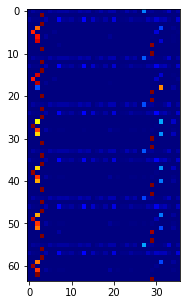

epochs: 31/100, train loss : 0.17570 train mse: 0.07315 train mae: 0.17816  validation loss: 0.17878 validation mse : 0.11455 validation mae: 0.22500
epochs: 32/100, train loss : 0.17249 train mse: 0.07296 train mae: 0.17791  validation loss: 0.17679 validation mse : 0.11485 validation mae: 0.22484
epochs: 33/100, train loss : 0.16947 train mse: 0.07283 train mae: 0.17778  validation loss: 0.17492 validation mse : 0.11529 validation mae: 0.22527
epochs: 34/100, train loss : 0.16663 train mse: 0.07267 train mae: 0.17754  validation loss: 0.17309 validation mse : 0.11263 validation mae: 0.22340
epochs: 35/100, train loss : 0.16394 train mse: 0.07263 train mae: 0.17760  validation loss: 0.17129 validation mse : 0.11012 validation mae: 0.22376
epochs: 36/100, train loss : 0.16140 train mse: 0.07255 train mae: 0.17755  validation loss: 0.16967 validation mse : 0.11290 validation mae: 0.22583
epochs: 37/100, train loss : 0.15900 train mse: 0.07237 train mae: 0.17712  validation loss: 0.16830

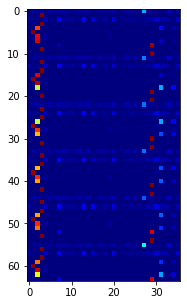

epochs: 41/100, train loss : 0.15052 train mse: 0.07192 train mae: 0.17668  validation loss: 0.16273 validation mse : 0.11487 validation mae: 0.22871
epochs: 42/100, train loss : 0.14864 train mse: 0.07158 train mae: 0.17613  validation loss: 0.16167 validation mse : 0.11811 validation mae: 0.23197
epochs: 43/100, train loss : 0.14684 train mse: 0.07146 train mae: 0.17582  validation loss: 0.16078 validation mse : 0.12321 validation mae: 0.23371
epochs: 44/100, train loss : 0.14512 train mse: 0.07122 train mae: 0.17550  validation loss: 0.15987 validation mse : 0.12087 validation mae: 0.23457
epochs: 45/100, train loss : 0.14348 train mse: 0.07106 train mae: 0.17529  validation loss: 0.15930 validation mse : 0.13445 validation mae: 0.24591
epochs: 46/100, train loss : 0.14190 train mse: 0.07080 train mae: 0.17483  validation loss: 0.15833 validation mse : 0.11465 validation mae: 0.23102
epochs: 47/100, train loss : 0.14038 train mse: 0.07035 train mae: 0.17417  validation loss: 0.15746

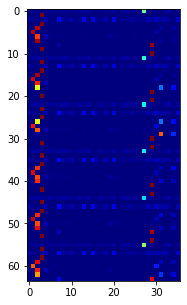

epochs: 51/100, train loss : 0.13483 train mse: 0.06906 train mae: 0.17229  validation loss: 0.15461 validation mse : 0.12962 validation mae: 0.24199
epochs: 52/100, train loss : 0.13356 train mse: 0.06906 train mae: 0.17220  validation loss: 0.15429 validation mse : 0.13760 validation mae: 0.24782
epochs: 53/100, train loss : 0.13234 train mse: 0.06862 train mae: 0.17161  validation loss: 0.15419 validation mse : 0.14943 validation mae: 0.25380
epochs: 54/100, train loss : 0.13116 train mse: 0.06855 train mae: 0.17170  validation loss: 0.15396 validation mse : 0.14159 validation mae: 0.24895
epochs: 55/100, train loss : 0.13001 train mse: 0.06804 train mae: 0.17093  validation loss: 0.15381 validation mse : 0.14542 validation mae: 0.25127
epochs: 56/100, train loss : 0.12890 train mse: 0.06779 train mae: 0.17058  validation loss: 0.15398 validation mse : 0.16378 validation mae: 0.26266
epochs: 57/100, train loss : 0.12782 train mse: 0.06753 train mae: 0.17008  validation loss: 0.15385

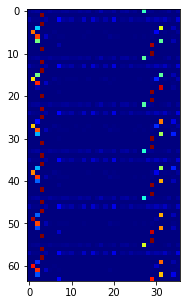

epochs: 61/100, train loss : 0.12381 train mse: 0.06634 train mae: 0.16862  validation loss: 0.15357 validation mse : 0.14633 validation mae: 0.24405
epochs: 62/100, train loss : 0.12289 train mse: 0.06627 train mae: 0.16871  validation loss: 0.15353 validation mse : 0.15050 validation mae: 0.24503
epochs: 63/100, train loss : 0.12198 train mse: 0.06596 train mae: 0.16816  validation loss: 0.15385 validation mse : 0.17374 validation mae: 0.26095
epochs: 64/100, train loss : 0.12112 train mse: 0.06654 train mae: 0.16943  validation loss: 0.15394 validation mse : 0.15998 validation mae: 0.25050
epochs: 65/100, train loss : 0.12027 train mse: 0.06582 train mae: 0.16822  validation loss: 0.15391 validation mse : 0.15215 validation mae: 0.24517
epochs: 66/100, train loss : 0.11944 train mse: 0.06559 train mae: 0.16762  validation loss: 0.15343 validation mse : 0.12173 validation mae: 0.22741
epochs: 67/100, train loss : 0.11863 train mse: 0.06552 train mae: 0.16713  validation loss: 0.15303

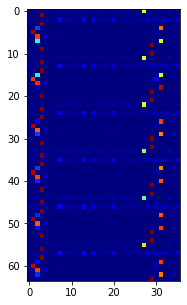

epochs: 71/100, train loss : 0.11578 train mse: 0.06656 train mae: 0.16893  validation loss: 0.15304 validation mse : 0.16308 validation mae: 0.25084
epochs: 72/100, train loss : 0.11508 train mse: 0.06529 train mae: 0.16698  validation loss: 0.15306 validation mse : 0.15473 validation mae: 0.24470
epochs: 73/100, train loss : 0.11438 train mse: 0.06416 train mae: 0.16521  validation loss: 0.15294 validation mse : 0.14453 validation mae: 0.23694
epochs: 74/100, train loss : 0.11369 train mse: 0.06334 train mae: 0.16400  validation loss: 0.15278 validation mse : 0.14118 validation mae: 0.23580
epochs: 75/100, train loss : 0.11301 train mse: 0.06265 train mae: 0.16277  validation loss: 0.15266 validation mse : 0.14349 validation mae: 0.23578
epochs: 76/100, train loss : 0.11234 train mse: 0.06202 train mae: 0.16173  validation loss: 0.15254 validation mse : 0.14368 validation mae: 0.23580
epochs: 77/100, train loss : 0.11168 train mse: 0.06153 train mae: 0.16081  validation loss: 0.15243

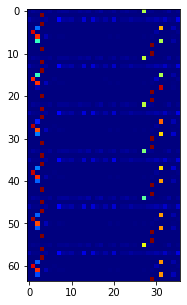

epochs: 81/100, train loss : 0.10915 train mse: 0.05996 train mae: 0.15802  validation loss: 0.15222 validation mse : 0.14471 validation mae: 0.23525
epochs: 82/100, train loss : 0.10856 train mse: 0.06036 train mae: 0.15903  validation loss: 0.15188 validation mse : 0.12514 validation mae: 0.21687
epochs: 83/100, train loss : 0.10798 train mse: 0.06050 train mae: 0.15940  validation loss: 0.15163 validation mse : 0.13080 validation mae: 0.22294
epochs: 84/100, train loss : 0.10741 train mse: 0.05975 train mae: 0.15781  validation loss: 0.15129 validation mse : 0.12304 validation mae: 0.21694
epochs: 85/100, train loss : 0.10684 train mse: 0.05933 train mae: 0.15703  validation loss: 0.15100 validation mse : 0.12618 validation mae: 0.21916
epochs: 86/100, train loss : 0.10628 train mse: 0.05881 train mae: 0.15607  validation loss: 0.15078 validation mse : 0.13255 validation mae: 0.22470
epochs: 87/100, train loss : 0.10573 train mse: 0.05830 train mae: 0.15516  validation loss: 0.15041

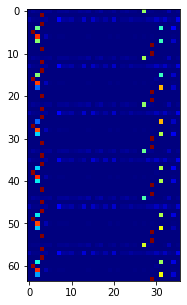

epochs: 91/100, train loss : 0.10362 train mse: 0.05754 train mae: 0.15393  validation loss: 0.15002 validation mse : 0.19987 validation mae: 0.27453
epochs: 92/100, train loss : 0.10313 train mse: 0.05866 train mae: 0.15633  validation loss: 0.15018 validation mse : 0.16413 validation mae: 0.24824
epochs: 93/100, train loss : 0.10264 train mse: 0.05782 train mae: 0.15431  validation loss: 0.15025 validation mse : 0.15760 validation mae: 0.24196
epochs: 94/100, train loss : 0.10216 train mse: 0.05744 train mae: 0.15353  validation loss: 0.15025 validation mse : 0.14945 validation mae: 0.23461
epochs: 95/100, train loss : 0.10169 train mse: 0.05714 train mae: 0.15282  validation loss: 0.15024 validation mse : 0.14975 validation mae: 0.23504
epochs: 96/100, train loss : 0.10122 train mse: 0.05660 train mae: 0.15189  validation loss: 0.15011 validation mse : 0.13760 validation mae: 0.22462
epochs: 97/100, train loss : 0.10075 train mse: 0.05613 train mae: 0.15084  validation loss: 0.14997

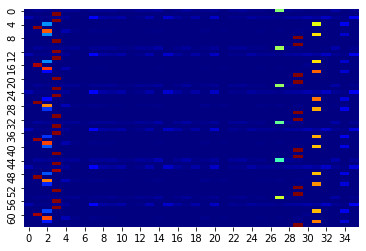

In [19]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}.gif', paths, fps=5)

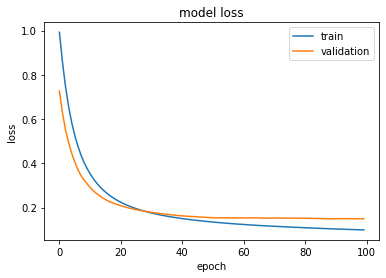

In [27]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [32]:
for i in range(10, 101 ,10) :
    model.load_weights(f"../data/model_weights/model_100_1320_682_cluster_2/model_{i}.pth")
    X_test, y_test = preprocessor.transform(test_data.values)
    scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

    print(f"Model MAE : {scores}")

    # Predict
    y_pred,_ = model.predict(X_test)
    y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
    comparison = np.hstack([y_pred, y_test])
    print(np.mean(np.abs(y_test - y_pred)))

Model MAE : 0.747111439704895
18155.851089969758
Model MAE : 0.747111439704895
17618.94677734375
Model MAE : 0.747111439704895
17594.490121254123
Model MAE : 0.747111439704895
16007.28352244089
Model MAE : 0.747111439704895
15591.265652564263
Model MAE : 0.747111439704895
18122.02872983871
Model MAE : 0.747111439704895
17799.672387623716
Model MAE : 0.747111439704895
16604.07169429298
Model MAE : 0.747111439704895
14333.87597369868
Model MAE : 0.747111439704895
14514.511208990103


In [34]:
X_test, y_test = preprocessor.transform(test_data.values)
model.load_weights(f"../data/model_weights/model_100_1320_682_cluster_2/model_100.pth")
y_pred,_ = model.predict(X_test)
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
comparison = np.hstack([y_pred, y_test])
print(np.mean(np.abs(y_test - y_pred)))

14514.511208990103


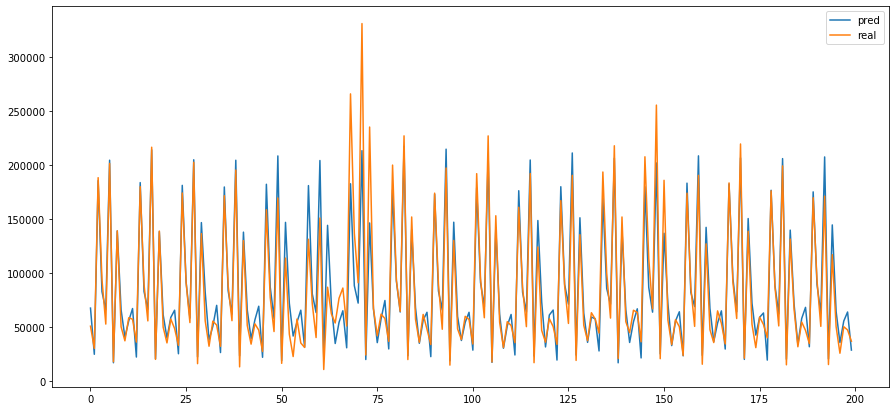

In [35]:
plt.figure(figsize=(15,7))
plt.plot(comparison[200:400])
plt.legend(['pred','real'])
plt.show()

In [36]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [37]:
final_dong_list = final_test_data.읍면동.unique()
final_test_data.drop(columns = '읍면동', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
final_test_data = final_test_data.set_index(['일자'])

In [39]:
a = scaler.transform(final_test_data)

In [40]:
np.asarray([a]).shape

(1, 1320, 36)

In [41]:
y_pred,_ = model.predict(np.asarray([a]))

In [42]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [47]:
y_pred

array([[ 40111.297],
       [ 61570.44 ],
       [ 79848.164],
       [ 28347.992],
       [202876.66 ],
       [ 91092.47 ],
       [ 66158.26 ],
       [231214.23 ],
       [ 14771.696],
       [165587.61 ],
       [ 69625.91 ],
       [ 36348.31 ],
       [ 63994.39 ],
       [ 72844.63 ],
       [ 24520.797],
       [207966.31 ],
       [ 91794.4  ],
       [ 65627.1  ],
       [231483.03 ],
       [ 20378.969],
       [159334.73 ],
       [ 71983.23 ],
       [ 32449.098],
       [ 63986.016],
       [ 71611.48 ],
       [ 26236.375],
       [202029.16 ],
       [ 94093.25 ],
       [ 70583.695],
       [231514.06 ],
       [ 15026.493],
       [160368.39 ],
       [ 78542.625],
       [ 36757.375],
       [ 70685.85 ],
       [ 77442.28 ],
       [ 29023.668],
       [201939.95 ],
       [ 89500.41 ],
       [ 72037.766],
       [230978.84 ],
       [ 22292.852],
       [155468.27 ],
       [ 76321.34 ],
       [ 39393.473],
       [ 58956.56 ],
       [ 79390.53 ],
       [ 2659

In [44]:
final_test_data = data[-look_back_window:]

In [48]:
list(final_dong_list)

['건입동',
 '대천동',
 '삼도1동',
 '안덕면',
 '연동',
 '외도동',
 '용담2동',
 '이도2동',
 '일도1동',
 '일도2동',
 '중문동']

In [49]:
final_dong_cluster_2 = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [50]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_2,np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [51]:
final_result[final_result['7_8월예측값'].astype('float') < 0 ] #음수값이 있나 확인

,읍면동,7_8월예측값


In [52]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_final_result.csv', encoding = 'cp949', index = False)